In [1]:
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
plt.rc('font', size=16)

import astropy.units as u
import astropy.constants as constants

import sys
import os

dir_current = globals()['_dh'][0]
dir_repo = dir_current+'/../../..'
dir_BinnedFit = dir_repo+"/BinnedFit"
dir_KLens = dir_repo+"/KLens"

sys.path.append(dir_BinnedFit)
from gen_mocks import gen_mock_tfCube
from chainTool import ChainTool
from gamma import GammaInference

sys.path.append(dir_KLens)
from KLtool import plot_specs

from IPython.display import display as ipython_display
from binnedFit_utilities import velocity_to_lambda

In [2]:
###### set up parameters ######

line_species='Halpha'

pars = {}
pars['g1'] = 0.0
pars['g2'] = 0.05
pars['sini'] = 0.8

pars['redshift'] = 0.4

pars['aspect'] = 0.2
pars['r_hl_image'] = 0.5
pars['r_hl_spec'] = 0.5

pars['theta_int'] = 0. #np.pi/3.

pars['slitWidth'] = 0.12
pars['ngrid'] = 128

pars['norm'] = 0.0

pars['Resolution'] = 5000.
pars['expTime'] = 60.*30. #60.*30.
pars['pixScale'] = 0.1185
pars['nm_per_pixel'] = 0.033
pars['throughput'] = 0.29
pars['psfFWHM'] = 0.5

pars['area'] = 3.14 * (1000./2.)**2 

pars['vcirc'] = 200.

pars['dx_gal'] = 0.
pars['dy_gal'] = 0.

linelist = np.empty(5,dtype=[('species',np.str_,16),
                                  ('lambda',np.float64),
                                  ('flux',np.float64)])
linelist['species'] = ['OIIa','OIIb','OIIIa','OIIIb','Halpha']
linelist['lambda'] =  [372.7092,372.9875,496.0295,500.8240,656.461]

fiber_SDSS = np.pi * 1.5**2
refSDSSspec = 3.*1e-17 * u.erg/u.second/u.Angstrom/u.cm**2
refSDSSspec = refSDSSspec.to(u.erg/u.second/u.nm/u.cm**2)

linelist['flux'] = refSDSSspec.value / fiber_SDSS  # [unit: erg/s/cm2/nm/arcsec2]

pars['linelist'] = linelist


In [3]:
#slitAngles = [0, np.pi/2]
slitAngles = None
#slitAngles = np.array([6.460695971136626, 6.460695971136626-90.])*np.pi/180.

dataInfo = gen_mock_tfCube(pars, 'Halpha', slits='both', noise_mode=0, slitAngles=slitAngles)

Set slitAngles at: 6.460695971136626 and -83.53930402886337.


In [4]:
active_par_key=['vcirc', 'sini', 'vscale', 'r_0', 'v_0', 'g1', 'g2',  'r_hl_image', 'theta_int', 'flux']

GI = GammaInference(dataInfo, active_par_key=active_par_key, par_fix=None, vTFR_mean=200.)

In [5]:
def query_logL(par_key, par_list, GI, par_base=None, add_prior=True):
    
    if par_base is None:
        par_base = GI.par_fid
        
    out_logL = [-1000]*len(par_list)
    
    for i, par_i in enumerate(par_list):
        par_in = GI.Pars.gen_par_dict(active_par=[par_i], active_par_key=[par_key], par_ref=par_base)
        
        if add_prior:
            logPrior_vcirc = GI.Pars.logPrior_vcirc(vcirc=par_in['vcirc'], sigma_TF_intr=GI.sigma_TF_intr, vTFR_mean=GI.vTFR_mean)
        else:
            logPrior_vcirc = 0.
        
        logL_image, model_img = GI._cal_loglike_image(par_in)
        logL_spec0, model_spec0 = GI._cal_loglike_spec(par_in, IDspec=0)
        logL_spec1, model_spec1 = GI._cal_loglike_spec(par_in, IDspec=1)

        out_logL[i] = logL_image+logL_spec0+logL_spec1+logPrior_vcirc
    
    return out_logL

In [6]:
# from tfCube2 import gen_grid

par_base = GI.par_fid
# gen_grid(par_base['g1'], 0.05, 20)

par_list = {
    'g1': np.linspace(-0.5,0.5,20),
    'g2': np.linspace(-0.5,0.5,20),
    'theta_int': np.linspace(-np.pi/2+0.001,np.pi/2-0.001,20),
    'sini': np.linspace(-0.99, 0.99, 20),
    'v_0': np.linspace(-10, 10, 20),
    'vcirc': np.linspace(10,400, 20),
    'vscale': np.linspace(0.1, 5, 20),
    'r_hl_image': np.linspace(0.2, 3, 20)
}

In [7]:
logL_list = {}
for key in ['g1', 'g2', 'theta_int', 'sini', 'v_0', 'vcirc', 'vscale', 'r_hl_image']:
    logL_list[key] = query_logL(par_key=key, par_list=par_list[key], GI=GI, par_base=GI.par_fid, add_prior=True)

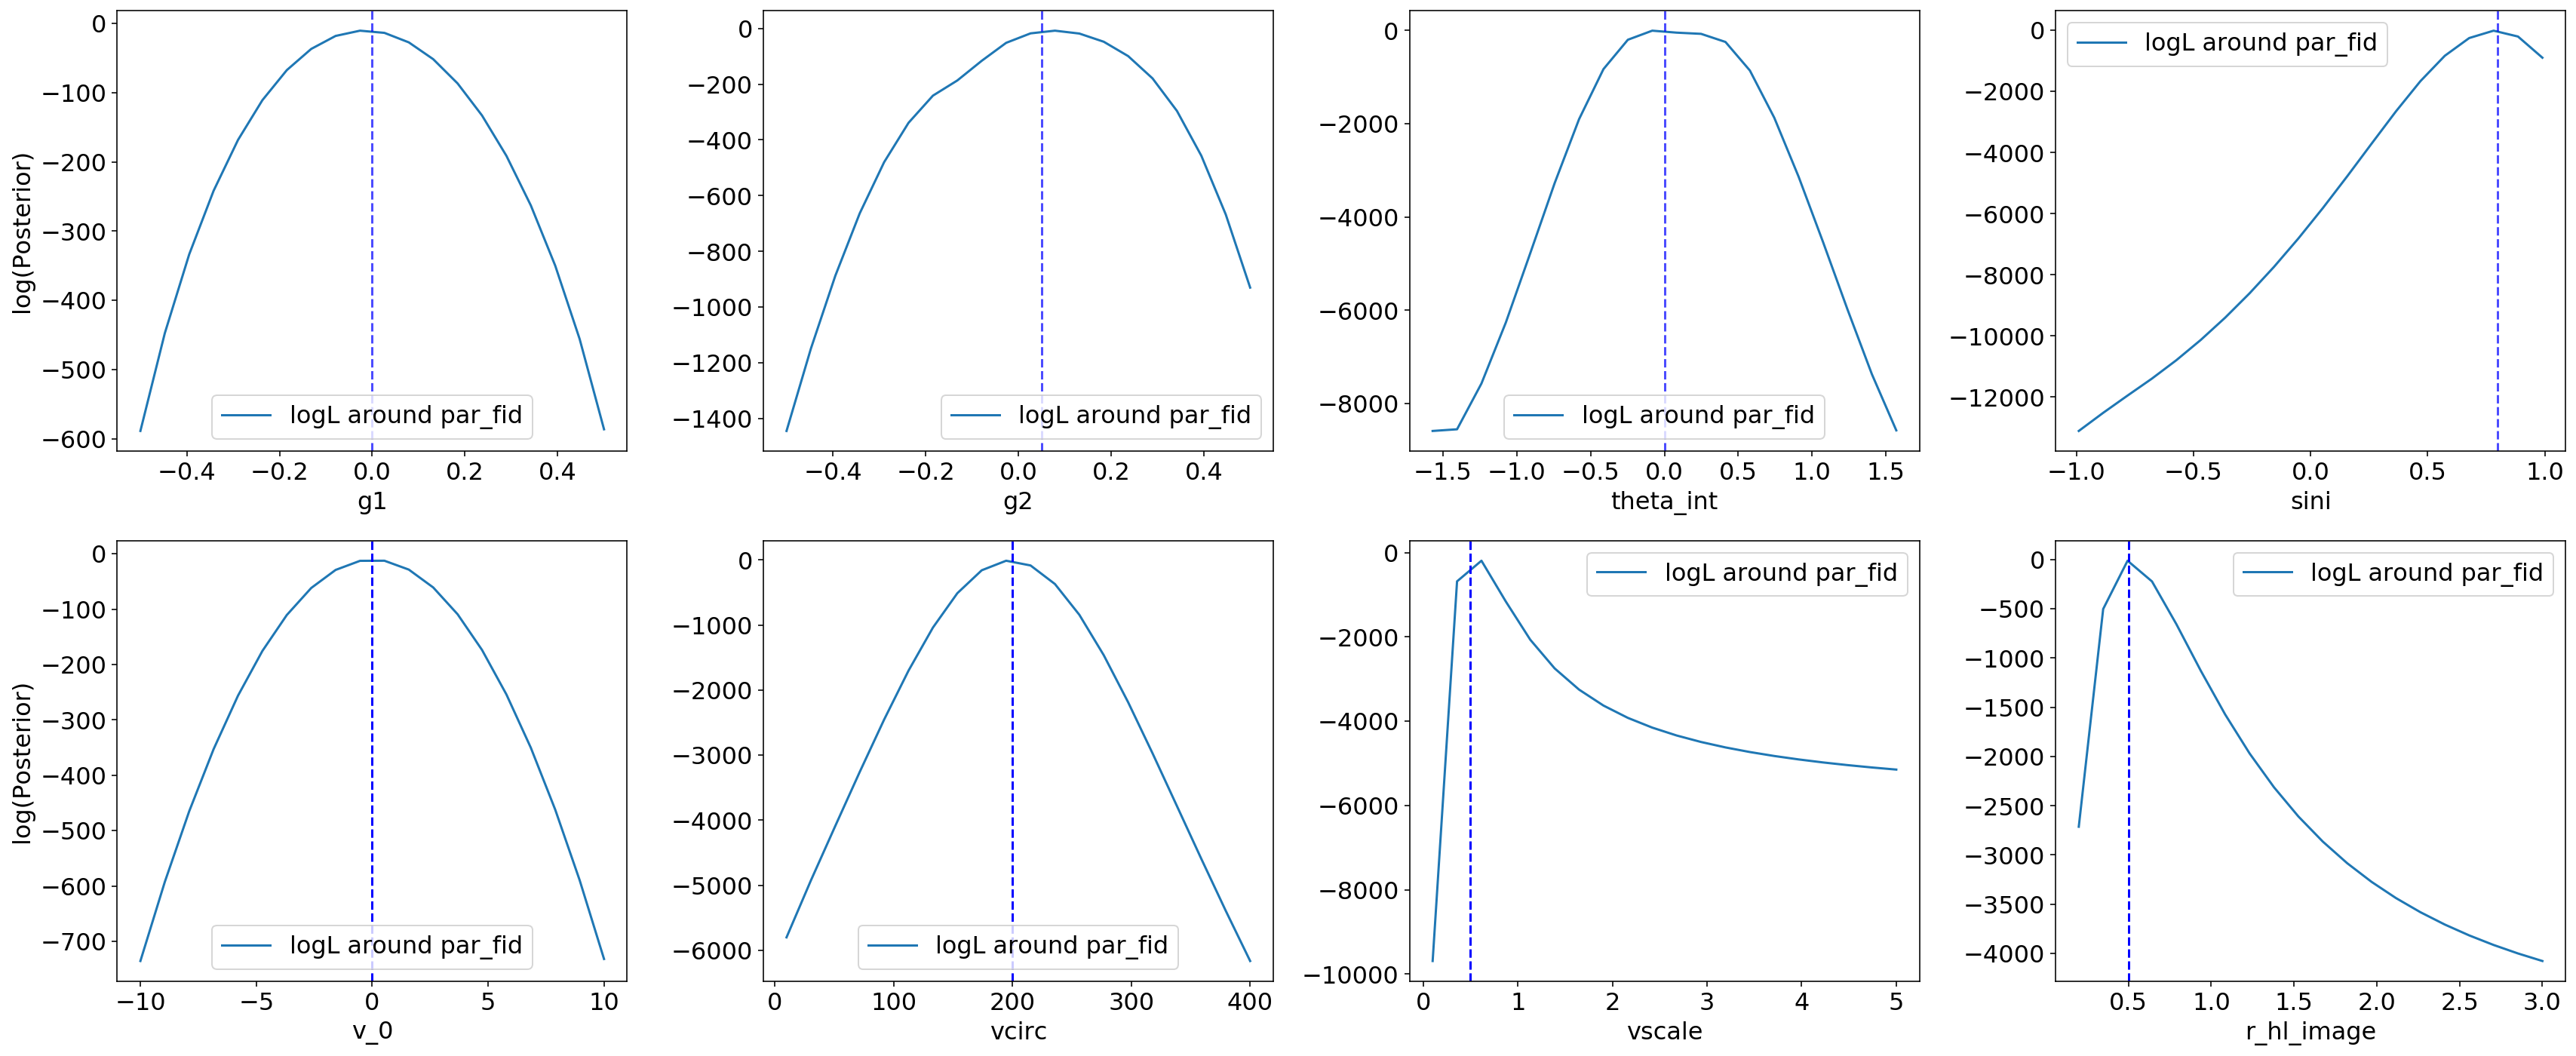

In [8]:
# ------ 
fig, ax = plt.subplots(2, 4, figsize=(24, 10))

upper_key = ['g1', 'g2', 'theta_int', 'sini']
for j, key in enumerate(upper_key):
    ax[0,j].plot(par_list[key], logL_list[key], label='logL around par_fid') # 
    ax[0,j].axvline(x=par_base[key], ls='--', color='blue', alpha=0.7)
    ax[0,j].set_xlabel(key)

lower_key = ['v_0', 'vcirc', 'vscale', 'r_hl_image']
for j, key in enumerate(lower_key):
    ax[1,j].plot(par_list[key], logL_list[key], label='logL around par_fid')
    ax[1,j].axvline(x=par_base[key], ls='--', color='blue', alpha=1)
    ax[1,j].set_xlabel(key)

for i in range(2):
    ax[i,0].set_ylabel('log(Posterior)')

    for j in range(4):
        ax[i,j].legend()

plt.tight_layout()

In [9]:
logL_list = {}
for key in ['g1', 'g2', 'theta_int', 'sini', 'v_0', 'vcirc', 'vscale', 'r_hl_image']:
    logL_list[key] = query_logL(par_key=key, par_list=par_list[key], GI=GI, par_base=GI.par_fid, add_prior=False)

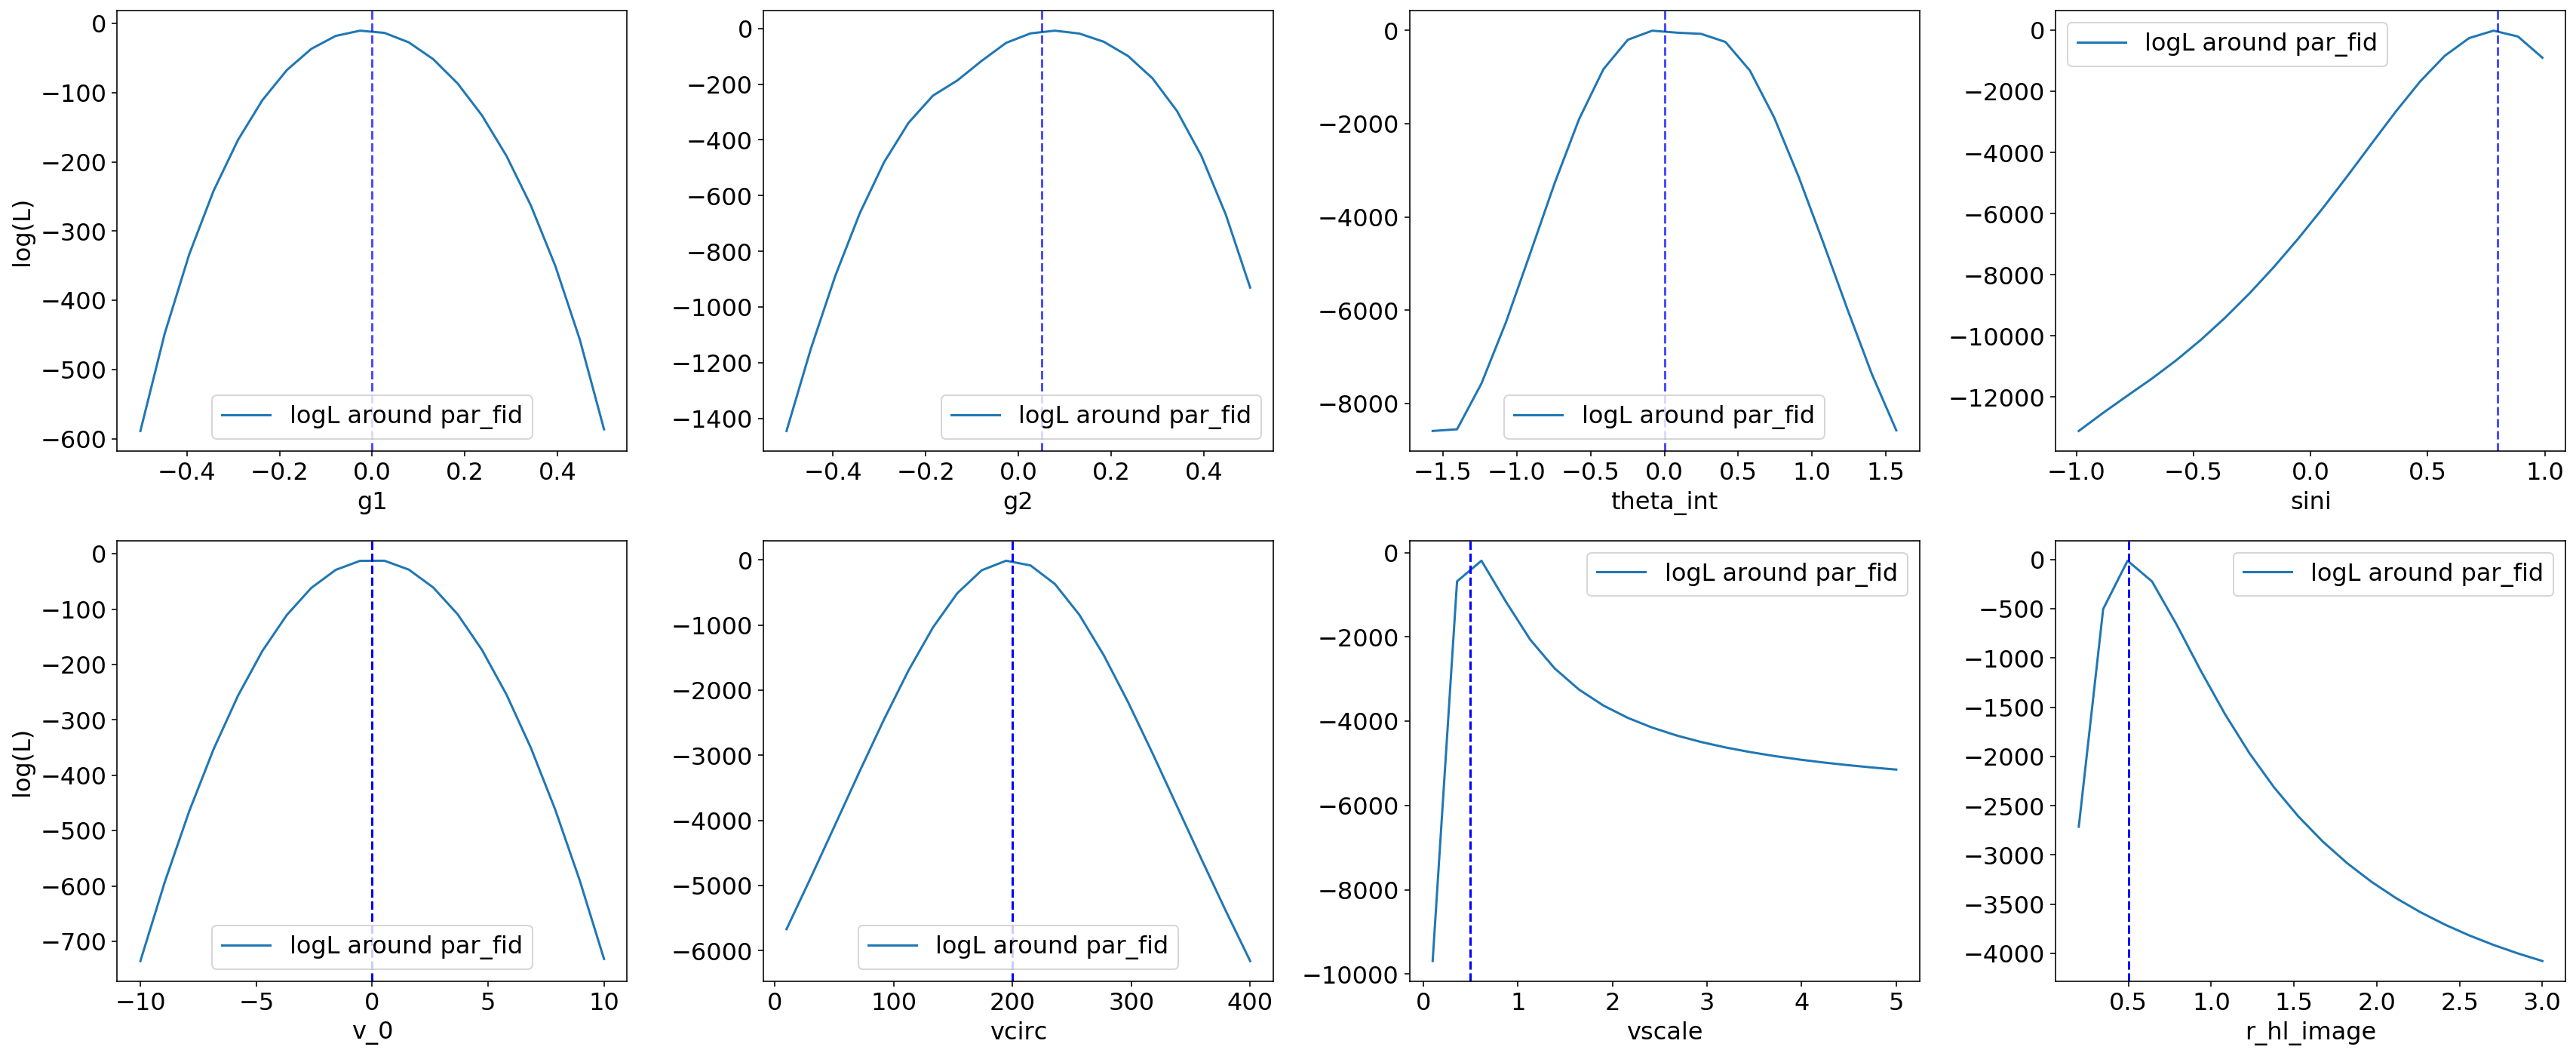

In [10]:
# ------ 
fig, ax = plt.subplots(2, 4, figsize=(24, 10))

upper_key = ['g1', 'g2', 'theta_int', 'sini']
for j, key in enumerate(upper_key):
    ax[0,j].plot(par_list[key], logL_list[key], label='logL around par_fid') # 
    ax[0,j].axvline(x=par_base[key], ls='--', color='blue', alpha=0.7)
    ax[0,j].set_xlabel(key)

lower_key = ['v_0', 'vcirc', 'vscale', 'r_hl_image']
for j, key in enumerate(lower_key):
    ax[1,j].plot(par_list[key], logL_list[key], label='logL around par_fid')
    ax[1,j].axvline(x=par_base[key], ls='--', color='blue', alpha=1)
    ax[1,j].set_xlabel(key)

for i in range(2):
    ax[i,0].set_ylabel('log(L)')

    for j in range(4):
        ax[i,j].legend()

plt.tight_layout()

# ------ End ------

In [11]:
GI.par_fid['g2']

0.05

In [12]:
par_in = GI.par_fid
par_in['sini'] = 0.0

In [13]:
logPrior_vcirc = GI.Pars.logPrior_vcirc(vcirc=par_in['vcirc'], sigma_TF_intr=GI.sigma_TF_intr, vTFR_mean=GI.vTFR_mean)
logL_image, model_img = GI._cal_loglike_image(par_in)
logL_spec0, model_spec0 = GI._cal_loglike_spec(par_in, IDspec=0)
logL_spec1, model_spec1 = GI._cal_loglike_spec(par_in, IDspec=1)

active_par_in = [par_in[key] for key in active_par_key]
totL = GI.cal_loglike(active_par_in)
print(f'tot logLike: {totL:.3f}')
print(f'  logPrior: {logPrior_vcirc:.3f}')
print(f'  logL_image: {logL_image:.3f}')
print(f'  logL_spec0: {logL_spec0:.3f}')
print(f'  logL_spec1: {logL_spec1:.3f}')

tot logLike: -6321.088
  logPrior: -0.000
  logL_image: -272.417
  logL_spec0: -5953.195
  logL_spec1: -95.476


Text(0, 0.5, 'logL')

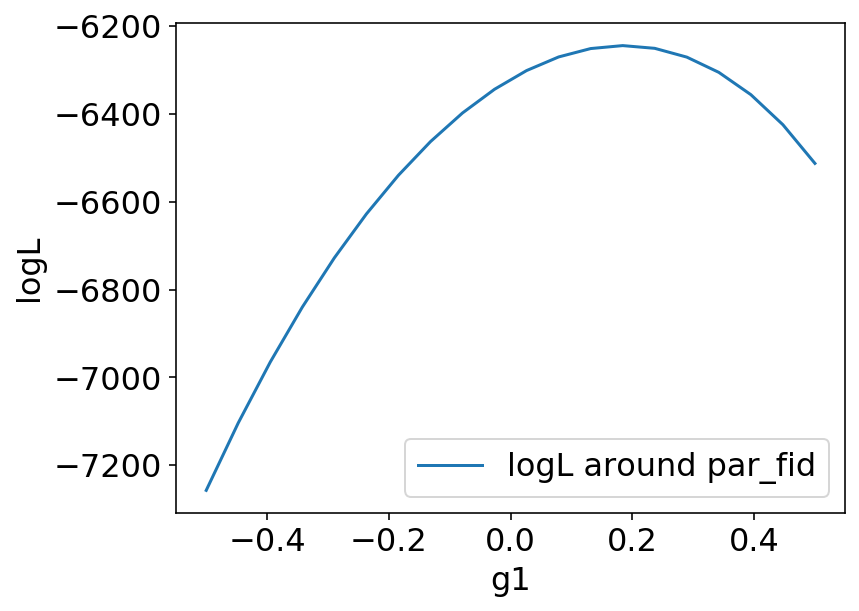

In [14]:
g1_list = np.linspace(-0.5,0.5,20)
out_logL = query_logL(par_key='g1', par_list=g1_list, GI=GI, par_base=GI.par_fid, add_prior=False)

# --- --- --- ---
fig, ax = plt.subplots(1, 1, figsize=(6, 4.5))
ax.plot(g1_list, out_logL, label='logL around par_fid')
ax.legend()

ax.set_xlabel('g1')
ax.set_ylabel('logL')

In [ ]:
dir_TNGcube = dir_repo + '/TNGcube'
sys.path.append(dir_TNGcube)
from binnedFit_utilities import cal_e_int, cal_theta_obs
from spec2D import Spec2D
from TNGcube import Image
from KLtool import find_flux_norm
from tfCube2 import TFCube, Parameters

def gen_mock_tfCube(pars=None, line_species='Halpha', slits='both', noise_mode=0):

    if pars is None:
        pars = Parameters()
    
    pars['flux'] = find_flux_norm(pars, R=1.5)
    
    eint_thy = cal_e_int(sini=pars['sini'], q_z=pars['aspect'])
    theta_obs = cal_theta_obs(g2=pars['g2'], e_int=eint_thy, theta_int=pars['theta_int'])
    
    slitAng_major_p = 0. #theta_obs
    slitAng_minor_p = np.pi/2. #theta_obs + np.pi / 2.
    print(f'slitAngle_major={slitAng_major_p*180./np.pi:.3f}')
    print(f'slitAngle_minor={slitAng_minor_p*180./np.pi:.3f}')
    
    if slits == 'major':
        pars['slitAngles'] = np.array([slitAng_major_p])
        
    elif slits == 'minor':
        pars['slitAngles'] = np.array([slitAng_minor_p])
        
    elif slits == 'both':
        pars['slitAngles'] = np.array([slitAng_major_p, slitAng_minor_p])
        
    # ------ generate mock data ------
    TF = TFCube(pars=pars, line_species=line_species)
    dataInfo = TF.gen_mock_data(noise_mode=noise_mode)

    # ------ modify the output of dataInfo to be compatible with binnedFit ------
    del dataInfo['par_meta']

    # change dataInfo['spec'] = [2Darr_1, 2Darr_2] from a list of np.array to be a list of Spec2D objects
    # making Spec2D objects
    for j in range(len(dataInfo['spec'])):
        dataInfo['spec'][j] = Spec2D(array=dataInfo['spec'][j], array_var=dataInfo['spec_variance'][j],spaceGrid=dataInfo['spaceGrid'], lambdaGrid=dataInfo['lambdaGrid'], line_species=line_species, z=dataInfo['par_fid']['redshift'], auto_cut=False)
    
    # make Image object
    dataInfo['image'] = Image(dataInfo['image'], dataInfo['spaceGrid'], array_var=dataInfo['image_variance'])

    dataInfo['eint_thy'] = eint_thy
    
    return dataInfo